In [1]:
import osiris_utils as ou
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Example notebook for the `Simulation` and `Diagnostic` classes

### `Simulation`
The `Simulation` class takes in:
- `simulation_folder`: the folder where the input deck is located
- `species`: the species in case we are interested in diagnostics that are species-specific (such as vfl1, T11, etc.)

Acts as a wrapper for the `Diagnostic` class, allowing for an easy access to diagnostics of the simulation using a **dictionary-like** syntax.

### `Diagnostic`

The `Diagnostic` class takes in:
- `simulation_folder`: the folder where the input deck is located
- `species`: the species in case we are interested in diagnostics that are species-specific (such as vfl1, T11, etc.)


The `Diagnostic` class has the some relevant methods and properties that you should be aware of:
- `get_quantity`: "loads" the quantity. Accessing the diagnostic through the `Simulations` using the dictionary-like syntax this will be called automatically.
- once the quantity is loaded, you can access the data at a specific time through indexing (e.g. `diag['vfl1'][0]` for the first time step). This doesn't store the data in memory, only uses a data generator to access the data (lazy loading).
- `load_all`: loads all the time steps of the quantity, storing it in memory
- `unload`: unloads the data from memory
- `time`: the time steps of the quantity at a specific index
- Has operator overloading for the `+`, `-`, `*`, `/` operators, allowing for easy manipulation of the data, even when it is not loaded in memory and is accessed through indexing.

In [2]:
# sim is a Simulation object
sim = ou.Simulation(input_deck_path="example_data/thermal.1d")

print("Simulation:")
print(sim)
print(sim.__dict__.keys())
print(f"\n")

# e3 is a Diagnostic object
e3 = ou.Diagnostic("example_data", "electrons")
# now we need to load the data
e3.get_quantity("e3") # it knows the path there since OSIRIS always saves the data in the same way

print("Diagnostic: (e3)")
print(e3)
print(e3.__dict__.keys())

Simulation:
dict_keys(['_input_deck_path', '_input_deck', '_species', '_simulation_folder', '_diagnostics', '_species_handler'])


Diagnostic: (e3)
dict_keys(['_species', '_dx', '_nx', '_x', '_dt', '_grid', '_axis', '_units', '_name', '_label', '_dim', '_ndump', '_maxiter', '_tunits', '_simulation_folder', '_input_deck', '_all_loaded', '_quantity', '_path', '_file_template', '_type'])


If the diagnostic that you want to access if related to a species, you need to access it by using the species name as the first key.

In [3]:
# An electric field if not relatec to a species, so you can access it by doing:
sim["e3"]

# To access a species-related diagnostic, you can do:
sim["electrons"]["vfl1"]

# To see the available species of a simulation, you can do:
sim.species

['electrons']

Notice that the `Diagnostic` class does not have `data` as the data is not saved in memory if `load_all` is not called. The data is accessed through the `__getitem__` method using indexing.

To get a `Diagnostic` from a `Simulation`, you can access it through the dictionary-like syntax, where the key is the name of the diagnostic (e.g. `sim['vfl1']` is a `Diagnostic` with the `vfl1` quantity).

In [4]:
sim["e3"] # This is equivalent to e3

print(sim["e3"])
print(sim["e3"].__dict__.keys())

dict_keys(['_species', '_dx', '_nx', '_x', '_dt', '_grid', '_axis', '_units', '_name', '_label', '_dim', '_ndump', '_maxiter', '_tunits', '_simulation_folder', '_input_deck', '_all_loaded', '_quantity', '_path', '_file_template', '_type', 'load_all'])


If we want to access the data of the diagnostic at a specific time, we can use the indexing syntax (e.g. `sim['vfl1'][0]` for the first time step, using a `Simulation`, or `e3[0]`, using the `Diagnostic` directly).

In [5]:
print(sim["e3"][100].shape) # nx
print(e3[100].shape)        # nx

print("Are they the same?", np.isclose(sim["e3"][100], e3[100]).all())

(500,)
(500,)
Are they the same? True


This is useful when we want to access a specific iteration of the diagnostic, without loading all the data in memory. 

For a quick plot, we can even use the other attributes of the `Diagnostic` class, such as `time`, `x` for the axis, of `axis` for info about the axis.

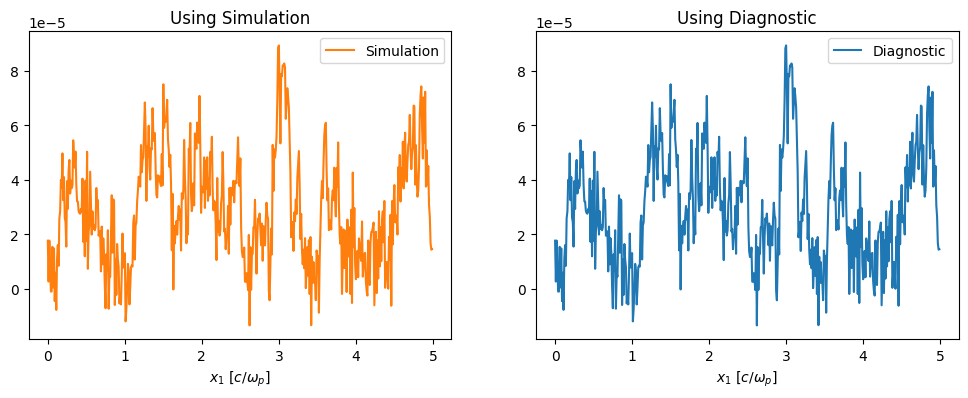

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(sim["e3"].x, sim["e3"][100], label="Simulation", c="tab:orange")
plt.title("Using Simulation")
plt.xlabel(sim["e3"].axis[0]["plot_label"])
plt.legend()

plt.subplot(122)
plt.plot(e3.x, e3[100], label="Diagnostic", c="tab:blue")
plt.title("Using Diagnostic")
plt.xlabel(e3.axis[0]["plot_label"])
plt.legend()
plt.show()

If we want to load all the data in memory, we can use the `load_all` method, which will load all the data in memory. This is useful to study how diagnostics vary in time, for example. 

The data is stored in the `data` attribute of the `Diagnostic` class. 

If we want to unload the data from memory, we can use the `unload` method.

From now on, I'll only use `sim[diagnostic]` to show what can be done with `Diagnostic` objects, but remember that you can access the `Diagnostic` object directly if you want to use the `load_all`, `unload`, `time`, `x`, and `axis` attributes.

In [7]:
sim["e3"].load_all()

# now, the data is loaded in memory
print(sim["e3"].data.shape) # (n_steps, nx)

sim["e3"].unload()

Loading all data from files. This may take a while.


Loading data: 100%|██████████| 254/254 [00:00<00:00, 909.66it/s]

(254, 500)
Unloading data from memory.


Since diagnostics have operator overloading, we can easily manipulate the data, even when it is not loaded in memory. For example, we can do `sim['vfl1'] + sim['e1']` to get the sum of the two diagnostics, or `sim['vfl1'] / sim['e1']` to get the division of the two diagnostics.

When operations are done, a new `Diagnostic` is created, with the new data. This new `Diagnostic` can be accessed through the indexing syntax, and the data can be loaded in memory using the `load_all` method.

In [8]:
sum_of_diag = sim["electrons"]["T11"] + sim["electrons"]["vfl1"] 

print(sum_of_diag)
print(sum_of_diag.__dict__.keys())

dict_keys(['_species', '_dx', '_nx', '_x', '_dt', '_grid', '_axis', '_units', '_name', '_label', '_dim', '_ndump', '_maxiter', '_tunits', '_simulation_folder', '_input_deck', '_all_loaded', '_quantity', '_type', '_data_generator'])


We can use the method of the `Diagnostic` class as usual, for example, `load_all`, and `unload`:

In [9]:
# we can load all the data at once
sum_of_diag.load_all()
print(sum_of_diag.data.shape) # (n_steps, nx)
sum_of_diag.unload()

This appears to be a derived diagnostic. Loading data from generators...


Loading data: 100%|██████████| 254/254 [00:00<00:00, 554.71it/s]

(254, 500)
Unloading data from memory.


And accessing a specific time step of the new `Diagnostic` is done through indexing, as usual.

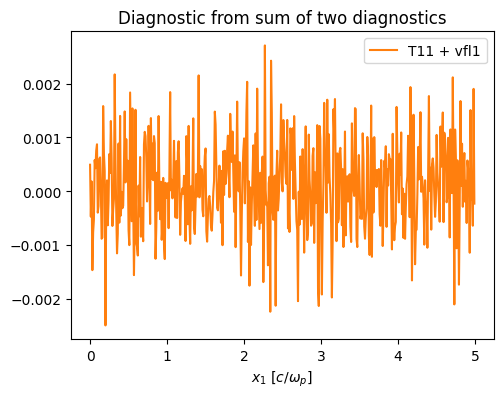

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(sum_of_diag.x, sum_of_diag[100], label="T11 + vfl1", c="tab:orange")
plt.title("Diagnostic from sum of two diagnostics")
plt.xlabel(sum_of_diag.axis[0]["plot_label"])
plt.legend()
plt.show()

This is really useful when we want a quantity that OSIRIS doesn't provide. For example, when the pressure is adiabatic, we can calculate the pressure using the formula `P = n * T`, where `P` is the pressure, `n` is the density, and `T` is the temperature. We can calculate the pressure using the formula `P = n * T` using the `Diagnostic` class, and then use the pressure to calculate the adiabatic index `gamma = 5/3` using the formula `gamma = P / (n * T)`.

In [11]:
nT = -1*sim["electrons"]["T11"]*sim["electrons"]["charge"] # -1 because we are dealing with electrons

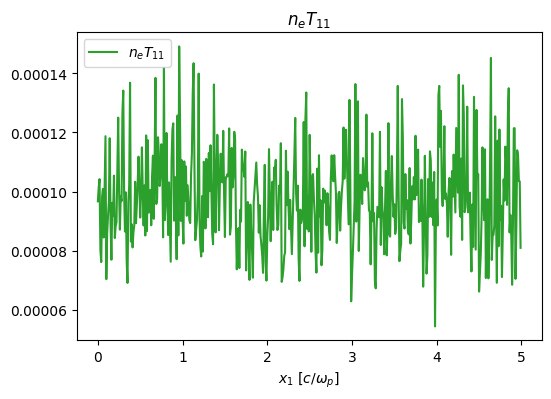

In [12]:
plt.figure(figsize=(6,4))
plt.plot(nT.x, nT[100], label=r"$n_eT_{11}$", c="tab:green")
plt.title(r"$n_eT_{11}$")
plt.xlabel(nT.axis[0]["plot_label"])
plt.legend()
plt.show()

If the `load_all` method is called before the operations, the whole data will be stored in the new quantity.

In [13]:
sim["electrons"]["vfl1"].load_all()
sim["electrons"]["charge"].load_all()

v_times_charge = sim["electrons"]["vfl1"]*sim["electrons"]["charge"]

print(v_times_charge)
print(v_times_charge.__dict__.keys())

Loading all data from files. This may take a while.


Loading data: 100%|██████████| 254/254 [00:00<00:00, 1089.04it/s]


Loading all data from files. This may take a while.


Loading data: 100%|██████████| 254/254 [00:00<00:00, 1115.20it/s]

Data already loaded.
dict_keys(['_species', '_dx', '_nx', '_x', '_dt', '_grid', '_axis', '_units', '_name', '_label', '_dim', '_ndump', '_maxiter', '_tunits', '_simulation_folder', '_input_deck', '_all_loaded', '_quantity', '_type', '_data'])


The whole data is computed if stored in the diagnostics before the operations

In [14]:
print(v_times_charge.data.shape)

(254, 500)


And it can be unloaded from memory using the `unload` method.

In [15]:
v_times_charge.unload()

# print something that checks that data is none
print("Is `v_times_charge.data` None?", v_times_charge._data is None)

Unloading data from memory.
Is `v_times_charge.data` None? True
